# Importing the Libraries

In [ ]:

import numpy as np
import pandas as pd

import nltk
nltk.download('stopwords')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import nltk
import re
from nltk.corpus import stopwords
import seaborn as sns
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Reading the Dataset

In [ ]:
df_true = pd.read_csv("/content/True.csv")
df_fake = pd.read_csv("/content/Fake.csv")

**Setting up a target variable and combining both the real and fake news datasets**

In [ ]:
df_true['target'] = 1
df_fake['target'] = 0
df = pd.concat([df_true, df_fake]).reset_index(drop = True)
df['original'] = df['title'] + ' ' + df['text']
df.head()

title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2  WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3  WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4  SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   

                 date  target  \
0  December 31, 2017        1   
1  December 29, 2017        1   
2  December 31, 2017        1   
3  December 30, 2017        1   
4  December 29, 2017        1   

                                            original  
0  As U.S. budget fight looms, Republicans flip t...  
1  U.S. military to accept transgender recruits o...  
2  Senior U.S. Republican senator: 'Let Mr. Muell...  
3  FBI Russia probe helped by Australian diplomat...  
4  Trump wants Postal Service to charge 'much mor...

**Lets take a note of the null values in the data**

In [ ]:
df.isnull().sum()

title       0
text        0
subject     0
date        0
target      0
original    0
dtype: int64

# Data Cleaning

In [ ]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 2 and token not in stop_words:
            result.append(token)

    return result

In [ ]:
# Transforming the unmatching subjects to the same notation
df.subject=df.subject.replace({'politics':'PoliticsNews','politicsNews':'PoliticsNews'})

# What is the distribution of Subjects between the True and Fake News?

In [ ]:
sub_tf_df=df.groupby('target').apply(lambda x:x['title'].count()).reset_index(name='Counts')
sub_tf_df.target.replace({0:'False',1:'True'},inplace=True)
fig = px.bar(sub_tf_df, x="target", y="Counts",
             color='Counts', barmode='group',
             height=400)
fig.show()

**Observation** The dataset looks really balanced and hence working on this is pretty easy. Thus we need not work on to make this dataset more balanced, and can safely assume this is a balanced dataset

# Which Subjects have received the most News Coverage?

In [ ]:
sub_check=df.groupby('subject').apply(lambda x:x['title'].count()).reset_index(name='Counts')
fig=px.bar(sub_check,x='subject',y='Counts',color='Counts',title='Count of News Articles by Subject')
fig.show()

# Can the News Headline be enough to predict if the news if fake or not? Lets us see in the following analysis

In [ ]:
df['clean_title'] = df['title'].apply(preprocess)
df['clean_title'][0]

['budget', 'fight', 'looms', 'republicans', 'flip', 'fiscal', 'script']

In [ ]:
df['clean_joined_title']=df['clean_title'].apply(lambda x:" ".join(x))

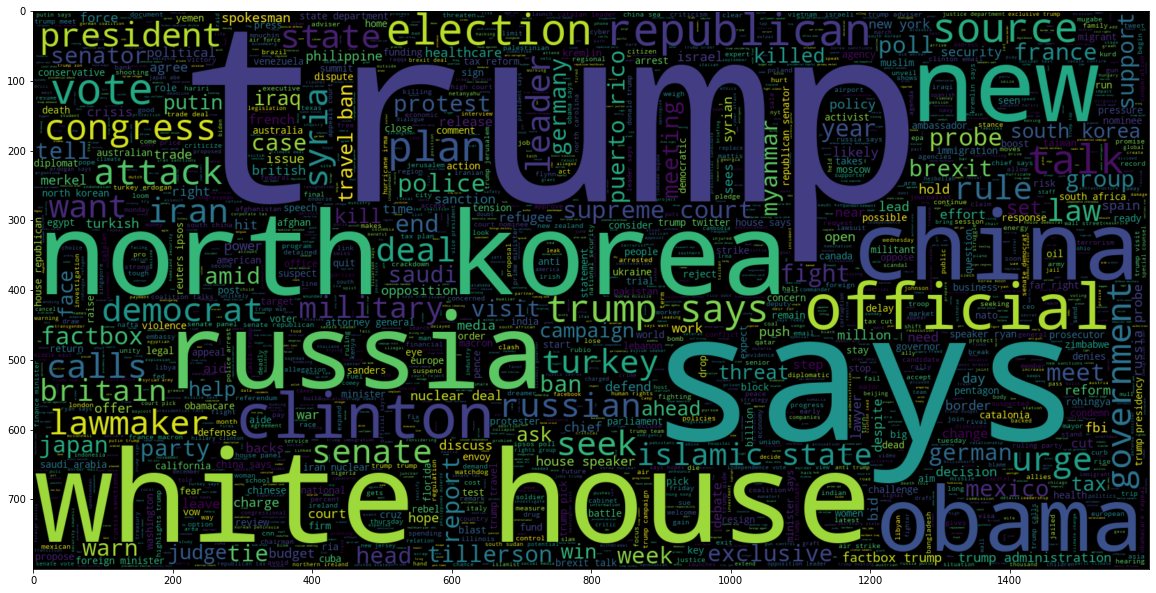

In [ ]:
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(df[df.target == 1].clean_joined_title))
plt.imshow(wc, interpolation = 'bilinear')

Word CLOUD using the fake news Headlines

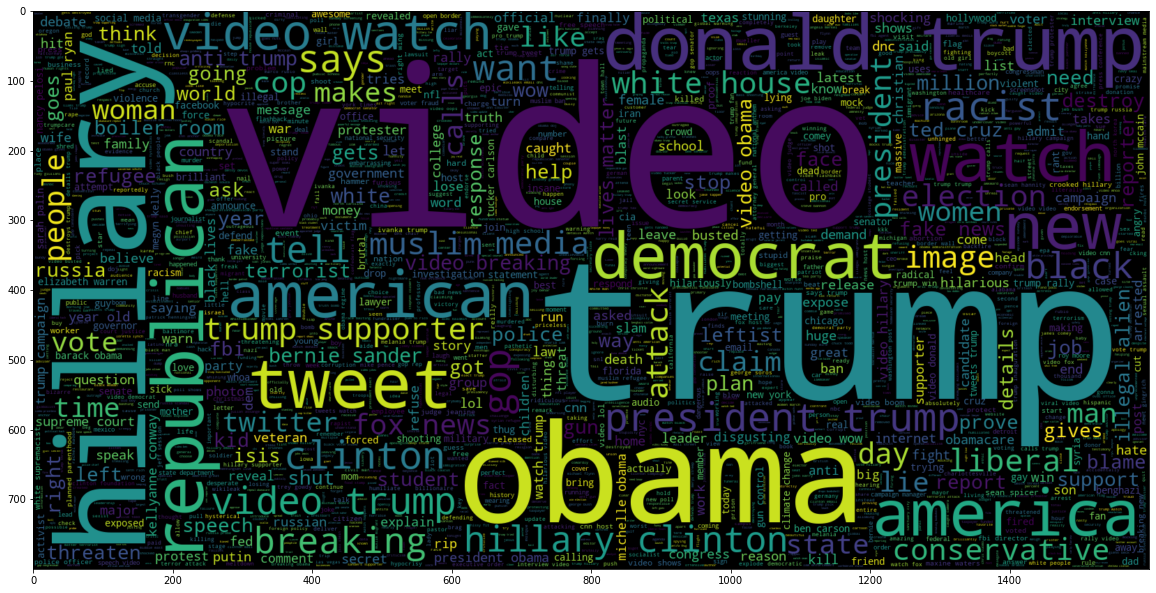

In [ ]:
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(df[df.target == 0].clean_joined_title))
plt.imshow(wc, interpolation = 'bilinear')

# Lets Look at the Count of Words Distribution in the Title

In [ ]:
maxlen = -1
for doc in df.clean_joined_title:
    tokens = nltk.word_tokenize(doc)
    if(maxlen<len(tokens)):
        maxlen = len(tokens)
print("The maximum number of words in a title is =", maxlen)
fig = px.histogram(x = [len(nltk.word_tokenize(x)) for x in df.clean_joined_title], nbins = 50)
fig.show()

The maximum number of words in a title is = 34


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.clean_joined_title, df.target, test_size = 0.2,random_state=2)
vec_train = CountVectorizer().fit(X_train)
X_vec_train = vec_train.transform(X_train)
X_vec_test = vec_train.transform(X_test)

1. Logistic Regression

In [ ]:
model = LogisticRegression(C=2)
model.fit(X_vec_train, y_train)
predicted_value = model.predict(X_vec_test)
accuracy_value = roc_auc_score(y_test, predicted_value)
print(accuracy_value)

0.947466974653341


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



2. **Decision Tree Classification**


In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
DT = DecisionTreeClassifier()
DT.fit(X_vec_train, y_train)
pred_dt = DT.predict(X_vec_test)
DT.score(X_vec_test, y_test)

0.9079064587973273

In [ ]:
prediction = []
for i in range(len(predicted_value)):
    if pred_dt[i].item() > 0.5:
        prediction.append(1)
    else:
        prediction.append(0)
cm = confusion_matrix(list(y_test), prediction)
plt.figure(figsize = (10, 10))
sns.heatmap(cm, annot = True,fmt='g',cmap='inferno')

3. **Gradient Boosting Classifier**

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
GBC = GradientBoostingClassifier(random_state=0)
GBC.fit(X_vec_train, y_train)
pred_gbc = GBC.predict(X_vec_test)
GBC.score(X_vec_test, y_test)

0.8216035634743876

4. **Random Forest Classifier**


In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
RFC = RandomForestClassifier(random_state=0)
RFC.fit(X_vec_train, y_train)
pred_rfc = RFC.predict(X_vec_test)
RFC.score(X_vec_test, y_test)

0.9350779510022271

5. **Stochastic Gradient Descent Classifier**

In [ ]:
from sklearn.linear_model import SGDClassifier

In [ ]:
sgd = SGDClassifier(random_state=0)
sgd.fit(X_vec_train, y_train)
pred_sgd = sgd.predict(X_vec_test)
sgd.score(X_vec_test, y_test)

0.9462138084632516

Accuracy Bar Graph

In [ ]:
from sklearn.metrics import accuracy_score


In [ ]:
acc1=accuracy_score(y_test,predicted_value )
acc2=accuracy_score(y_test,pred_dt)
acc3=accuracy_score(y_test,pred_gbc)
acc4=accuracy_score(y_test,pred_rfc)
acc5=accuracy_score(y_test,pred_sgd)

In [ ]:
labels={'LogisticRegression':acc1,'DecisionTreeClassification':acc2,'GradientBoostingClassifier':acc3,'RandomForestClassifier':acc4, 'StochasticGradientDescentClassifier':acc5
        }
for model,accuracy in labels.items():
    print(str(model)+' : '+str(accuracy))

LogisticRegression : 0.9472160356347439
DecisionTreeClassification : 0.9079064587973273
GradientBoostingClassifier : 0.8216035634743876
RandomForestClassifier : 0.9350779510022271
StochasticGradientDescentClassifier : 0.9462138084632516


<BarContainer object of 5 artists>

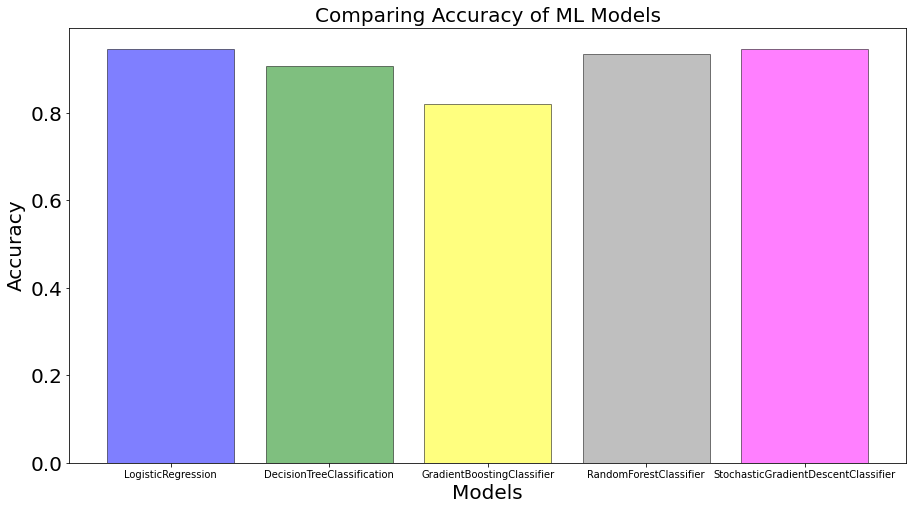

In [ ]:
plt.figure(figsize=(15,8))
plt.title('Comparing Accuracy of ML Models',fontsize=20)
colors=['blue','green','yellow','grey','magenta','cyan']
plt.xticks(fontsize=10,color='black')
plt.yticks(fontsize=20,color='black')
plt.ylabel('Accuracy',fontsize=20)
plt.xlabel('Models',fontsize=20)
plt.bar(labels.keys(),labels.values(),edgecolor='black',color=colors, linewidth=1,alpha=0.5)

The CONFUSION MATRIX

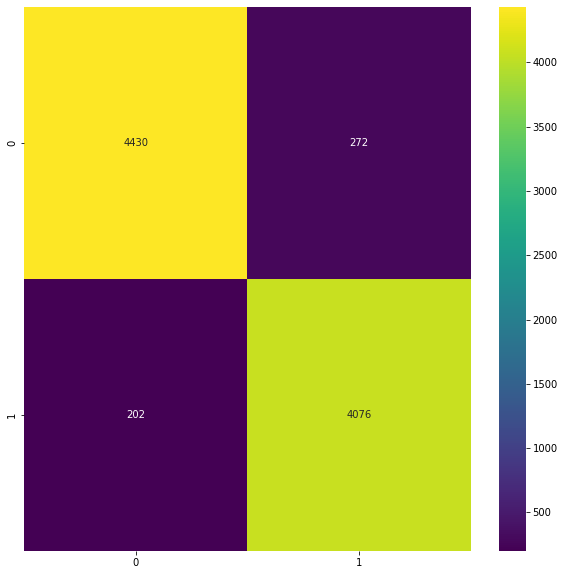

In [ ]:
cm = confusion_matrix(list(y_test), predicted_value)
plt.figure(figsize = (10, 10))
sns.heatmap(cm, annot = True,fmt='g',cmap='viridis')

In [ ]:
df['clean_text'] = df['text'].apply(preprocess)
df['clean_joined_text']=df['clean_text'].apply(lambda x:" ".join(x))

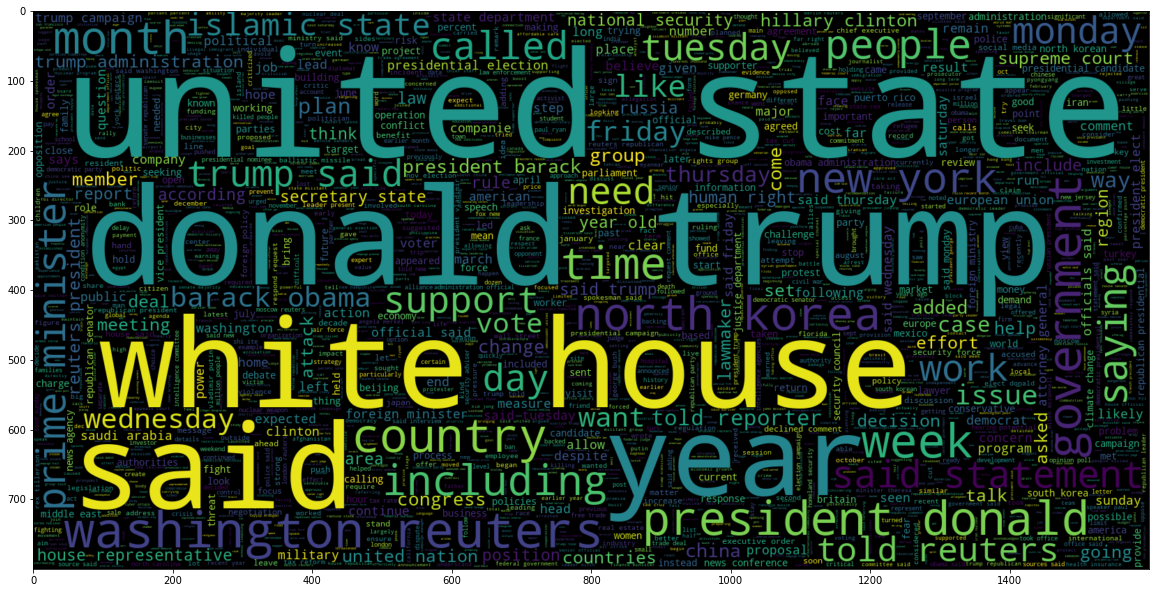

In [ ]:
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(df[df.target == 1].clean_joined_text))
plt.imshow(wc, interpolation = 'bilinear')

Now Creating a Word Cloud using the Fake News Writeups


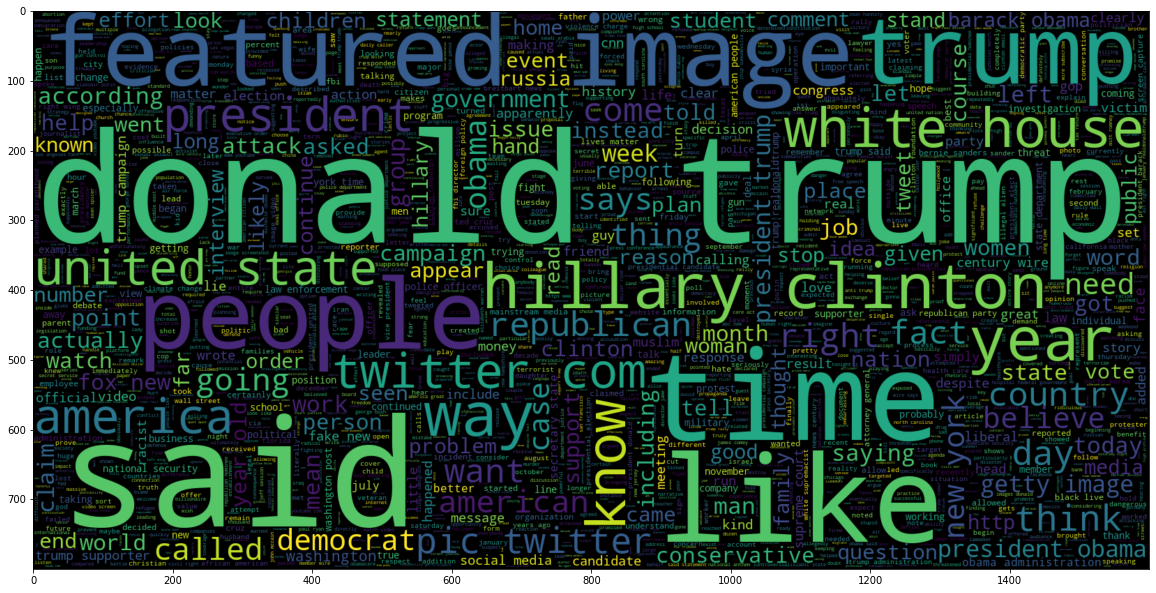

In [ ]:
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(df[df.target == 0].clean_joined_text))
plt.imshow(wc, interpolation = 'bilinear')

# Lets try to identify the distribution of word counts in the texts

In [ ]:
maxlen = -1
for doc in df.clean_joined_text:
    tokens = nltk.word_tokenize(doc)
    if(maxlen<len(tokens)):
        maxlen = len(tokens)
print("The maximum number of words in a News Content is =", maxlen)
fig = px.histogram(x = [len(nltk.word_tokenize(x)) for x in df.clean_joined_text], nbins = 50)
fig.show()

The maximum number of words in a News Content is = 4574


In [ ]:

X_train, X_test, y_train, y_test = train_test_split(df.clean_joined_text, df.target, test_size = 0.2,random_state=2)
vec_train = CountVectorizer().fit(X_train)
X_vec_train = vec_train.transform(X_train)
X_vec_test = vec_train.transform(X_test)
model = LogisticRegression(C=2.5)
model.fit(X_vec_train, y_train)
predicted_value = model.predict(X_vec_test)
accuracy_value = roc_auc_score(y_test, predicted_value)
print(accuracy_value)

0.9953661308915527


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Confusion Matrix

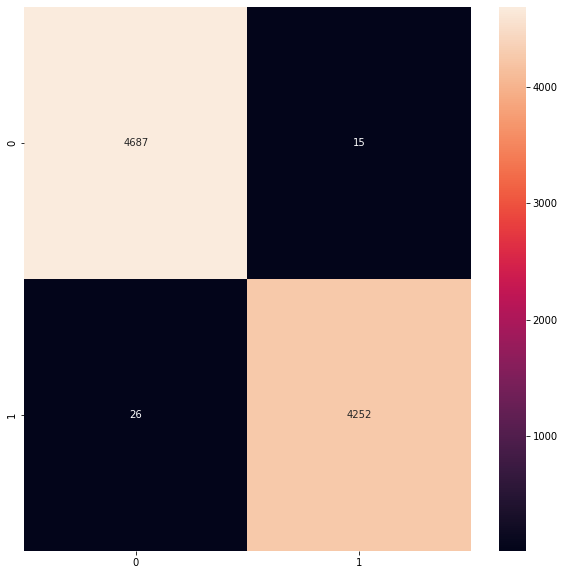

In [ ]:
prediction = []
for i in range(len(predicted_value)):
    if predicted_value[i].item() > 0.5:
        prediction.append(1)
    else:
        prediction.append(0)
cm = confusion_matrix(list(y_test), prediction)
plt.figure(figsize = (10, 10))
sns.heatmap(cm, annot = True,fmt='g')

**Observation** This is Awesome! 4662 Contents of Fake News were classified as Fake, while 4281 Real ones were rightly predicted as well. Now we have only 41 missclassified sets. Massive improvement from our first model. But can we try to improve this any further?
What if, we combine the title and content, would it give us any better result- No harm in trying. Lets check that out in the following section

# Lets try to analyze, how accurately can we predict if we consider the entire news- Title and Content!!!

In [ ]:
df['clean_final'] = df['original'].apply(preprocess)
df['clean_joined_final']=df['clean_final'].apply(lambda x:" ".join(x))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.clean_joined_final, df.target, test_size = 0.2,random_state=0)
vec_train = CountVectorizer().fit(X_train)
X_vec_train = vec_train.transform(X_train)
X_vec_test = vec_train.transform(X_test)
model = LogisticRegression(C=3)
model.fit(X_vec_train, y_train)
predicted_value = model.predict(X_vec_test)
accuracy_value = roc_auc_score(y_test, predicted_value)
print(accuracy_value)

0.9966717508706907


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



**Observation** 99.67%!!! Quite Perfect Score! So considering both the title and the content of the news we have been able to predict the nature of the news! For our final consolation, lets take a look at the confusion matrix!

# Confusion Matrix

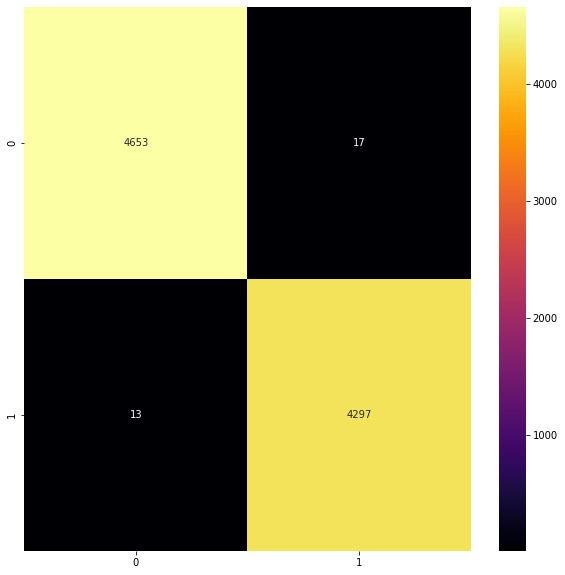

In [ ]:
prediction = []
for i in range(len(predicted_value)):
    if predicted_value[i].item() > 0.5:
        prediction.append(1)
    else:
        prediction.append(0)
cm = confusion_matrix(list(y_test), prediction)
plt.figure(figsize = (10, 10))
sns.heatmap(cm, annot = True,fmt='g',cmap='inferno')